# Proyecto de CNN: Clasificación de Drones vs Pájaros

En este apartado, desarrollaremos una red neuronal convolucional (CNN) para clasificar imágenes en dos categorías: drones y pájaros. Comenzaremos trabajando con un dataset que contiene imágenes de ambas clases, organizadas en carpetas para entrenamiento, validación y prueba.

### Carga del Dataset

Hemos cargado y preparado el dataset utilizando TensorFlow. El dataset está organizado en carpetas para entrenamiento, validación y prueba. Cada carpeta contiene imágenes de drones y pájaros.

Para cargar las imágenes, hemos definido las siguientes funciones:

1. **`get_image_paths(images_dir)`**: Obtiene las rutas de todas las imágenes en un directorio específico.
2. **`load_and_preprocess_image(path)`**: Carga una imagen desde su ruta, la decodifica, la redimensiona a 224x224 píxeles y normaliza sus valores entre 0 y 1.
3. **`prepare_dataset(image_paths, batch_size=32, training=False)`**: Prepara un dataset de TensorFlow a partir de las rutas de las imágenes. Si el dataset es para entrenamiento, se aplica un barajado de datos.

Los datasets resultantes son:
- **`train_ds`**: Dataset para entrenamiento.
- **`valid_ds`**: Dataset para validación.
- **`test_ds`**: Dataset para prueba.

Estos datasets están listos para ser utilizados en el entrenamiento y evaluación de la red neuronal.

In [11]:
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

def get_image_label_lists(images_dir, labels_dir):
    image_paths, class_labels = [], []
    
    for filename in os.listdir(images_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(images_dir, filename)
            label_path = os.path.join(labels_dir, filename.replace('.jpg', '.txt'))
            class_id = 0

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    try:
                        class_id = int(f.readline().split()[0])
                    except:
                        pass

            image_paths.append(img_path)
            class_labels.append(class_id)
    
    return image_paths, class_labels

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

def prepare_dataset(image_paths, class_labels, batch_size=32, training=False):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, class_labels))
    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(*get_image_label_lists("./Dataset/train/images", "./Dataset/train/labels"), training=True)
valid_ds = prepare_dataset(*get_image_label_lists("./Dataset/valid/images", "./Dataset/valid/labels"))
test_ds  = prepare_dataset(*get_image_label_lists("./Dataset/test/images",  "./Dataset/test/labels"))



### Distribución de Clases en el Dataset

Hemos revisado la distribución de las clases en las distintas carpetas del dataset:

- **Train**: 21868 imágenes de drones (DTR) y 14778 imágenes de pájaros (BTR).
- **Valid**: 2078 imágenes de drones (DV) y 1402 imágenes de pájaros (BV).
- **Test**: 1056 imágenes de drones (DT) y 722 imágenes de pájaros (BT).

Esta distribución nos permite evaluar el desempeño de nuestra red neuronal en diferentes etapas: entrenamiento, validación y prueba.

In [12]:
from collections import Counter
import os

def count_btr_dtr(directory):
    btr_count = 0
    dtr_count = 0
    bv_count = 0
    dv_count = 0
    bt_count = 0
    dt_count = 0
    
    for root, _, files in os.walk(directory):
        for file in files:
            if "BTR" in file:
                btr_count += 1
            elif "DTR" in file:
                dtr_count += 1
            elif "BV" in file:
                bv_count += 1
            elif "DV" in file:
                dv_count += 1
            elif "BT" in file:
                bt_count += 1
            elif "DT" in file:
                dt_count += 1
    
    return Counter({"BTR": btr_count, "DTR": dtr_count, "BV": bv_count, "DV": dv_count, "BT": bt_count, "DT": dt_count})

dataset_dir = "./Dataset"
btr_dtr_counts = count_btr_dtr(dataset_dir)
print(btr_dtr_counts)

Counter({'DTR': 21868, 'BTR': 14778, 'DV': 2078, 'BV': 1402, 'DT': 1056, 'BT': 722})


### Visualización de Imágenes del Dataset

Es importante verificar visualmente algunas imágenes del dataset para asegurarnos de que las imágenes se han cargado correctamente y que corresponden a las clases esperadas (drones y pájaros).

A continuación, realizaremos una visualización de algunas imágenes de los datasets de entrenamiento, validación y prueba. Esto nos permitirá confirmar que las imágenes han sido preprocesadas correctamente (redimensionadas a 224x224 píxeles y normalizadas).

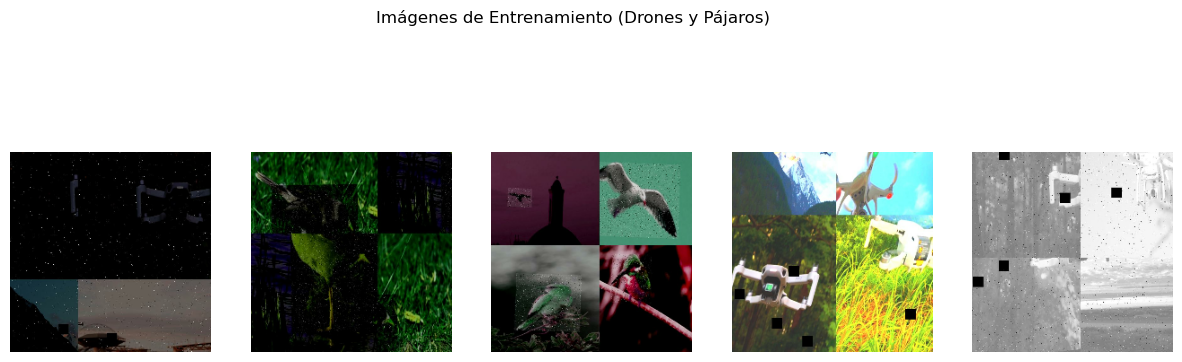

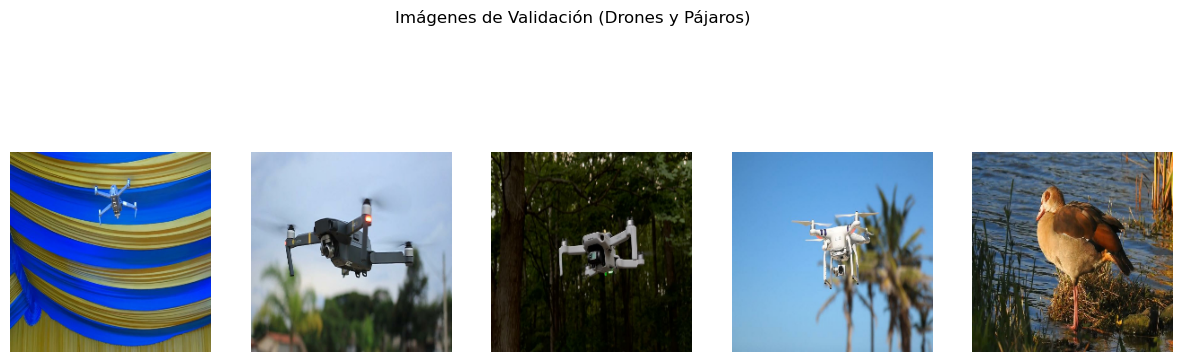

2025-04-09 17:29:53.737277: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


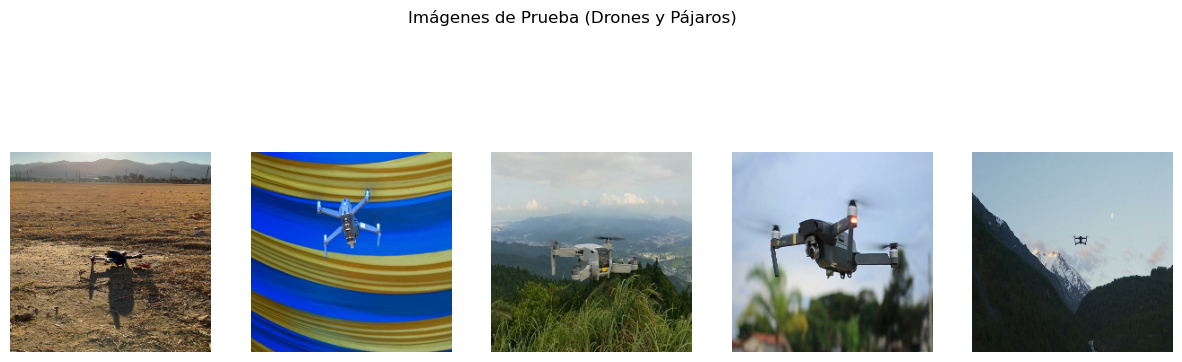

In [13]:
import matplotlib.pyplot as plt

def visualize_images(dataset, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_images)):  # Desempaquetar la tupla
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Visualizar imágenes del dataset de entrenamiento
visualize_images(train_ds, "Imágenes de Entrenamiento (Drones y Pájaros)")

# Visualizar imágenes del dataset de validación
visualize_images(valid_ds, "Imágenes de Validación (Drones y Pájaros)")

# Visualizar imágenes del dataset de prueba
visualize_images(test_ds, "Imágenes de Prueba (Drones y Pájaros)")

### Estadísticas de las Imágenes del Dataset

Para asegurarnos de que las imágenes han sido correctamente preprocesadas (redimensionadas a 224x224 píxeles y normalizadas), extraemos algunas estadísticas de los datasets de entrenamiento, validación y prueba. Esto incluye el número total de muestras y las dimensiones de las imágenes. Estas estadísticas nos permitirán verificar que el proceso de preprocesamiento se ha aplicado correctamente.

In [14]:
def dataset_statistics(dataset, name):
    num_samples = sum(1 for _ in dataset.unbatch())
    image_shape = next(iter(dataset.unbatch()))[0].shape
    print(f"{name} - Número de muestras: {num_samples}, Dimensiones de las imágenes: {image_shape}")

dataset_statistics(train_ds, "Train Dataset")
dataset_statistics(valid_ds, "Validation Dataset")
dataset_statistics(test_ds, "Test Dataset")

Train Dataset - Número de muestras: 18323, Dimensiones de las imágenes: (224, 224, 3)
Validation Dataset - Número de muestras: 1740, Dimensiones de las imágenes: (224, 224, 3)
Test Dataset - Número de muestras: 889, Dimensiones de las imágenes: (224, 224, 3)


### Verificación de Normalización de los Píxeles

En este apartado, verificamos si los píxeles de las imágenes han sido correctamente normalizados al rango [0, 1]. La normalización es un paso crucial para mejorar la convergencia durante el entrenamiento de la red neuronal, ya que asegura que los valores de entrada estén en un rango uniforme, facilitando el aprendizaje de los parámetros del modelo.

In [15]:
def check_pixel_range(dataset, name):
    min_pixel = float('inf')
    max_pixel = float('-inf')
    for image, _ in dataset.unbatch().take(100):
        min_pixel = min(min_pixel, tf.reduce_min(image).numpy())
        max_pixel = max(max_pixel, tf.reduce_max(image).numpy())
    print(f"{name} - Rango de píxeles: [{min_pixel}, {max_pixel}]")

check_pixel_range(train_ds, "Train Dataset")
check_pixel_range(valid_ds, "Validation Dataset")
check_pixel_range(test_ds, "Test Dataset")

Train Dataset - Rango de píxeles: [0.0, 1.0]
Validation Dataset - Rango de píxeles: [0.0, 1.0]
Test Dataset - Rango de píxeles: [0.0, 1.0]


### Creación del Modelo: Modelos Baseline y Métricas de Evaluación

#### Modelo CNN:
- Diseña una arquitectura de CNN con varias capas convolucionales seguidas de capas de pooling y, finalmente, capas densas.
- Entrena este modelo y evalcion de su rendimiento.

#### Métricas de evaluación:
- **Exactitud (accuracy)**: Proporción de predicciones correctas.
- **Precisión, recall y F1-score**: Especialmente útiles en casos de clases desbalanceadas.
- **Matriz de confusión**: Permite visualizar el desempeño en cada clase, identificando falsos positivos y falsos negativos.
- **Curvas ROC y AUC**: Evalúan la robustez del modelo en clasificación binaria.

In [16]:
def check_for_null_values(dataset, name):
    has_nan = False
    for image, _ in dataset.unbatch():
        if tf.reduce_any(tf.math.is_nan(image)):
            has_nan = True
            break
    if has_nan:
        print(f"{name} contiene valores nulos.")
    else:
        print(f"{name} no contiene valores nulos.")

check_for_null_values(train_ds, "Train Dataset")
check_for_null_values(valid_ds, "Validation Dataset")
check_for_null_values(test_ds, "Test Dataset")

Train Dataset no contiene valores nulos.
Validation Dataset no contiene valores nulos.
Test Dataset no contiene valores nulos.


In [17]:
from tensorflow.keras import layers, models

# Construcción del modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilación del modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=1)

# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

573/573 ━━━━━━━━━━━━━━━━━━━━ 307s 535ms/step - accuracy: 0.9883 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8887 - loss: 50.2712
Test Loss: 44.287681579589844, Test Accuracy: 0.8998875021934509


In [24]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

# 1. Cargar imágenes y etiquetas desde carpetas
def get_image_label_lists(images_dir, labels_dir):
    image_paths = []
    class_labels = []

    for filename in os.listdir(images_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(images_dir, filename)
            label_filename = filename.replace('.jpg', '.txt')
            label_path = os.path.join(labels_dir, label_filename)

            class_id = 0  # Valor por defecto

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if len(lines) > 0:
                        tokens = lines[0].split()
                        if len(tokens) > 0:
                            try:
                                class_id = int(tokens[0])
                            except ValueError:
                                pass

            image_paths.append(img_path)
            class_labels.append(class_id)

    return image_paths, class_labels

# 2. Directorios de entrenamiento, validación y test
train_images_dir = "./Dataset/train/images"
train_labels_dir = "./Dataset/train/labels"
valid_images_dir = "./Dataset/valid/images"
valid_labels_dir = "./Dataset/valid/labels"
test_images_dir = "./Dataset/test/images"
test_labels_dir = "./Dataset/test/labels"

# 3. Obtener rutas e identificadores de clase
train_image_paths, train_class_labels = get_image_label_lists(train_images_dir, train_labels_dir)
valid_image_paths, valid_class_labels = get_image_label_lists(valid_images_dir, valid_labels_dir)
test_image_paths, test_class_labels   = get_image_label_lists(test_images_dir, test_labels_dir)

# 4. Preprocesamiento de imágenes
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image

# 5. Preparar datasets con imágenes y etiquetas
def prepare_dataset(image_paths, labels, batch_size=32, training=False):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 6. Crear datasets
train_ds = prepare_dataset(train_image_paths, train_class_labels, training=True)
valid_ds = prepare_dataset(valid_image_paths, valid_class_labels)
test_ds  = prepare_dataset(test_image_paths, test_class_labels)

# 7. Definir modelo CNN baseline
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# 8. Compilar modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 9. Entrenar modelo
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=1)


573/573 ━━━━━━━━━━━━━━━━━━━━ 307s 534ms/step - accuracy: 0.9958 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images in test_ds:
    preds = model.predict(images)
    y_pred.extend(preds)


y_true = test_class_labels
y_pred = np.array(y_pred).flatten()
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(y_true, y_pred_labels, target_names=["Bird", "Drone"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

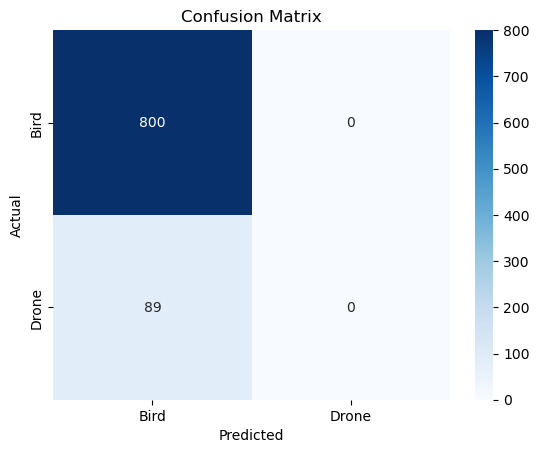

In [26]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Bird", "Drone"], yticklabels=["Bird", "Drone"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


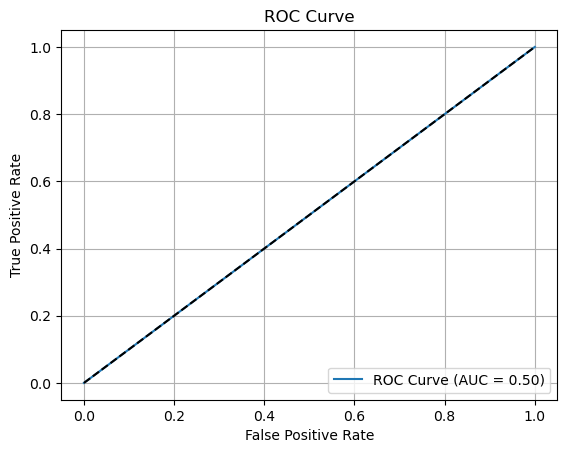

In [27]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
